# CS 123A Project: Building a protein secondary structure predictor
Rachel Stanik, Phuong Tran


# Step 1: Importing libraries

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Step 2: Reading in the Data and Parsing the Data

In [2]:
file = open("dataset.txt", "r")

## Parse the data

Data must be in following format: <br>
'> Protein sequence name' <br>
'\n' <br>
'< amino acid sequence>' <br>
'\n' <br>
'< secondary structure>' <br>
'\n' <br>

In [3]:
def parse_data(file, sequences, structures):
    lines = file.readlines()
    file.close()
    new_seq = False
    new_struct = False
    full_seq = ""
    full_struct = ""
    
    #Parse the text
    for line in lines:
        #new protein sequence and structure
        if ">" in line:
            new_seq = True
            new_struct = False
            full_seq = ""
            full_struct = ""
            #print(line) # for debugging
            
        #end of the amino acid sequence
        elif new_seq and line == "\n":
            new_seq = False
            new_struct = True
            sequences.append(full_seq)
            #print(full_seq) #for debugging
            
        elif new_seq:
            line = line.strip()
            full_seq += line
            
        #end of secondary structure
        elif new_struct and line == "\n":
            structures.append(full_struct)
            #print(full_struct) #for debugging
            #print() #for debugging
            new_seq = False
            new_struct = False
            
        elif new_struct:
            line = line.strip()
            full_struct += line
    
sequences = []
structures = []
parse_data(file, sequences, structures)

### Average Length of sequence

In [4]:
def avg_seqs_length(sequences):
    avg_length = 0
    for seq in sequences:
        avg_length += len(seq)
    return avg_length / len(sequences)
avg_seqs_length(sequences)

324.42857142857144

### Functions for debugging 
Ensure that the length of the amino acid sequence matches the length of the structure sequence

In [5]:
# For Debugging
def validate_lengths(seq, struct):
    for i in range(0, len(seq)):
#         print("\nNEW SEQUENCE")
#         print(seq[i])
#         print("Length of sequence {}: {}, Length of the structure: {}".format(i, len(seq[i]), len(struct[i])))
#         print(len(seq[i]) == len(struct[i]))
        if len(seq[i]) != len(struct[i]):
            print("ERROR")
            print(seq[i])
            print("Length of sequence {}: {}, Length of the structure: {}".format(i, len(seq[i]), len(struct[i])))
            break
        
print("Read in {} amino acid sequences.".format(len(sequences)))
print("Read in {} secondary structure sequences.".format(len(structures)))

validate_lengths(sequences, structures)

Read in 21 amino acid sequences.
Read in 21 secondary structure sequences.


# Step 3: Data Preprocessing

## Process the amino acid sequence
### Perform one-hot encoding
Referenced: https://dmnfarrell.github.io/bioinformatics/mhclearning for encoding

In [6]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def one_hot_encode(seq):
    #amino acids not in the sequence
    missing_amino_acids = list(set(codes) - set(seq))
    seq_df = pd.DataFrame(list(seq)) 
    #Create a df with only 0's and the 'missing' amino acids
    index = pd.DataFrame(np.zeros((len(seq),len(missing_amino_acids)),dtype=int),columns=missing_amino_acids) 
    df = seq_df[0].str.get_dummies(sep=',')
    #join the df with the zero df on their indices (position of the amino acid)
    df = df.join(index)
    df = df.sort_index(axis=1)
    return df

#Create a list of dataframes
encoded_sequences = []
for sequence in sequences:
    encoded_sequences.append(one_hot_encode(sequence))


### Example of the result after encoding
An example dataframe for the first sequence

In [7]:
print('Encoded sequence for: \n{}\n'.format(sequences[0]))
print('''The index represents the sequence position.
A value of "1" indicates the amino acid in that position.''')
encoded_sequences[0]

Encoded sequence for: 
MSEKKQPVDLGLLEEDDEFEEFPAEDWAGLDEDEDAHVWEDNWDDDNVEDDFSNQLRAELEKHGYKMETS

The index represents the sequence position.
A value of "1" indicates the amino acid in that position.


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
67,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Combine all encoded amino acid sequences into one Dataframe

In [8]:
seq_df = pd.DataFrame(columns=codes)
for seq in encoded_sequences:
    seq_df = pd.concat([seq_df, seq])
seq_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
633,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
634,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
635,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Process the target variable (secondary structure)
### Convert from Category (-,E,H) to Numerical Values

In [9]:
struct_df = pd.DataFrame(columns=['struct'])
for struct in structures:
    struct_df = pd.concat([struct_df, pd.DataFrame(list(struct), columns=['struct'])])

#for graphing later
graph_df = struct_df.copy()

#convert ['-' 'H' 'E'] into numerical values
struct_df['struct'] = struct_df['struct'].astype('category')
legend = dict(enumerate(struct_df['struct'].cat.categories))
print(legend)
struct_df['struct'] = struct_df['struct'].cat.codes
struct_df

{0: '-', 1: 'E', 2: 'H'}


,struct
0,0
1,0
2,0
3,0
4,0
...,...
632,2
633,0
634,0
635,0


### See how many coils, sheets, and helixes there are

In [10]:
counts = struct_df.struct.value_counts()
counts.apply(lambda x: x / counts.sum())

0    0.454132
2    0.316454
1    0.229414
Name: struct, dtype: float64

### Let's make a bar graph to visualize this

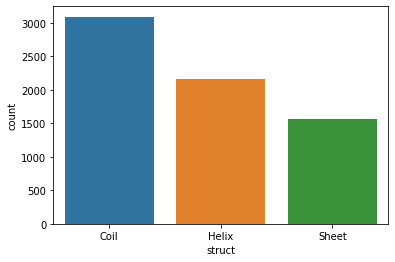

In [11]:
ax = sns.countplot(x='struct', data=graph_df)
target_names=["Coil", "Helix", "Sheet"]
ax.set_xticklabels(target_names)
ax

## Validate the number of rows match in both dataframes

In [12]:
len(seq_df.index) == len(struct_df.index)

True

# Step 4: Model Building

## Train-Test Split

In [13]:
#70-30 Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(seq_df, struct_df, test_size=0.3, random_state=1)
print('x_train', x_train.shape, '\ny_train', y_train.shape, '\nx_test', x_test.shape, '\ny_test', y_test.shape)

x_train (4769, 20) 
y_train (4769, 1) 
x_test (2044, 20) 
y_test (2044, 1)


## Build Neural Network

In [14]:
#model = MLPClassifier() #Default Model

#Tuned Model (Logistic)
model = MLPClassifier(activation='logistic', hidden_layer_sizes=(500, 100), max_iter=1000,alpha=0.001, n_iter_no_change=50) 

#hyperbolic tan function improved accuracy by .40% 
#model = MLPClassifier(activation='tanh', hidden_layer_sizes=(500,100), max_iter=1000,alpha=0.001, n_iter_no_change=50) 
model.fit(x_train, y_train.values.ravel())

MLPClassifier(activation='logistic', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(500, 100), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=50, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [15]:
model.n_layers_

4

# Step 5: Model Evaluation

## Accuracy

In [16]:
preds = model.predict(x_test)
print('Accuracy for test set: {:.2f}%'.format(accuracy_score(y_test, preds)*100))
print('Accuracy for training data: {:.2f}%'.format(accuracy_score(y_train, model.predict(x_train))*100))

Accuracy for test set: 51.22%
Accuracy for training data: 52.78%


## Confusion Matrices
Followed: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix as a guide to making it pretty

In [17]:
#needed for using matplotlib in jupyter notebook
%matplotlib inline

def create_cm(title, cm):
    #'-' = Coil, 'E' = Sheet, 'H' = Helix
    df_cm = pd.DataFrame(cm, ['Coil','Sheet','Helix'],
                      ['Coil', 'Sheet', 'Helix'])
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")

    # fix for mpl bug that cuts off top/bottom of seaborn viz 
    # link: https://github.com/mwaskom/seaborn/issues/1773
    b, t = plt.ylim() # the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.title(title)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    plt.show()

### Confusion Matrix For Test Set

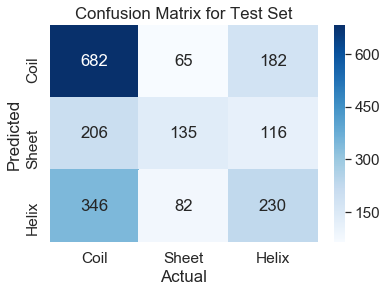

In [18]:
array_test = confusion_matrix(y_test, preds)
create_cm("Confusion Matrix for Test Set", array_test)

### Confusion Matrix For Training Set

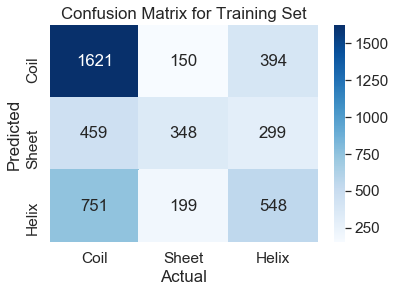

In [19]:
array_train= confusion_matrix(y_train, model.predict(x_train))
create_cm("Confusion Matrix for Training Set", array_train)

## Precision and Recall

<b>[From Wikipedia:](https://en.wikipedia.org/wiki/Precision_and_recall)</b> "Suppose a computer program for recognizing dogs in photographs identifies<br>
8 dogs in a picture containing 12 dogs and some cats. Of the 8 identified as dogs, 5 actually<br>
are dogs (true positives), while the rest are cats (false positives). The program's precision<br>
is 5/8 while its recall is 5/12. When a search engine returns 30 pages only 20 of which were<br>
relevant while failing to return 40 additional relevant pages, its precision is 20/30 = 2/3 while<br>
its recall is 20/60 = 1/3. So, in this case, precision is "how useful the search results are", and<br>
recall is "how complete the results are"."<br>
<br>
Precison: # of correctly identified / # of all identified <br>
Recall: # of correctly identified / # of all actual

In [20]:
# we use the confusion matrix (cm_array) to make these calculations
def calculate_precision(cm_array, position, name):
    precision = cm_array[position][position] / np.sum(cm_array[position])
    print("Precision for {}: {:.2f}%".format(name, precision*100))

def calculate_recall(cm_array, position, name):
    total = 0
    for i in range(0, len(cm_array)):
        total += cm_array[i][position]
    recall = cm_array[position][position] / total
    print("Recall for {}: {:.2f}%".format(name, recall*100))

### Test Set Precision and Recall

In [21]:
calculate_precision(array_test, 0, "coil")
calculate_recall(array_test, 0, "coil")
print()
calculate_precision(array_test, 1, "sheet")
calculate_recall(array_test, 1, "sheet")
print()
calculate_precision(array_test, 2, "helix")
calculate_recall(array_test, 2, "helix")

Precision for coil: 73.41%
Recall for coil: 55.27%

Precision for sheet: 29.54%
Recall for sheet: 47.87%

Precision for helix: 34.95%
Recall for helix: 43.56%


### Training Set Precision and Recall

In [22]:
calculate_precision(array_train, 0, "coil")
calculate_recall(array_train, 0, "coil")
print()
calculate_precision(array_train, 1, "sheet")
calculate_recall(array_train, 1, "sheet")
print()
calculate_precision(array_train, 2, "helix")
calculate_recall(array_train, 2, "helix")

Precision for coil: 74.87%
Recall for coil: 57.26%

Precision for sheet: 31.46%
Recall for sheet: 49.93%

Precision for helix: 36.58%
Recall for helix: 44.16%


### Classification Report using sklearn's library
I found out about this after doing the above code, but I wanted to see what it did here. 

In [24]:
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.55      0.73      0.63       929
           1       0.48      0.30      0.37       457
           2       0.44      0.35      0.39       658

    accuracy                           0.51      2044
   macro avg       0.49      0.46      0.46      2044
weighted avg       0.50      0.51      0.49      2044



## Step 6: Predict

### Read in the file containing the amino acid sequences to predict their secondary structure

In [25]:
file_predict=open("sample_predict_seq.txt", "r")

Note: 
    Make sure to have at least one newline character ("\n") at the end of the text file <br>
    (i.e. press enter after the last sequence)

In [26]:
def parse_aa_seqs(file, predict_seqs):
    lines = file.readlines()
    file.close()
    new_seq = False
    full_seq = ""
    
    #Parse the text
    for line in lines:
        #new protein sequence
        if ">" in line:
            #print(line) #for debugging
            new_seq = True
            full_seq = ""
        
        #end of amino acid sequence
        elif new_seq and line == "\n":
            #print("{}\n".format(full_seq)) #for debugging
            predict_seqs.append(full_seq)
            new_seq = False
            
        elif new_seq:
            line = line.strip()
            full_seq += line
            

In [27]:
predict_seqs = []
parse_aa_seqs(file_predict, predict_seqs)

### Encode the sequences (One-hot Encoding)

In [28]:
encoded_predict_seqs = []
for seq in predict_seqs:
    encoded_predict_seqs.append(one_hot_encode(seq))
encoded_predict_seqs[0]

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
723,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
724,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
725,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Predict

In [29]:
predictions = []
for seq in encoded_predict_seqs:
    predictions.append(model.predict(seq))

### Change numbers back to symbols
Change the results from numerical to symbols for the secondary structures ('-' = coil, 'H' = helix, 'E' = Sheet)

In [30]:
def convert_num_to_struct(seq, legend):
    symbols = ""
    for item in seq:
        if item == 0:
            symbols += legend[0]
        elif item == 1:
            symbols += legend[1]
        elif item == 2:
            symbols += legend[2]
    return symbols

In [31]:
pred_structs = []
for seq in predictions:
    pred_structs.append(convert_num_to_struct(seq, legend))

## Print the Results

In [32]:
for i in range(0, len(pred_structs)):
    print("Amino Acid Sequence {}: ".format(i + 1))
    print(predict_seqs[i])
    print()
    print("Predicted Secondary Structure: ")
    print(pred_structs[i])
    print()

Amino Acid Sequence 1: 
STLPRFDSVDLGNAPVPADAARRFEELAAKAGTGEAWETAEQIPVGTLFNEDVYKDMDWLDTYAGIPPFVHGPYATMYAFRPWTIRQYAGFSTAKESNAFYRRNLAAGQKGLSVAFDLPTHRGYDSDNPRVAGDVGMAGVAIDSIYDMRELFAGIPLDQMSVSMTMNGAVLPILALYVVTAEEQGVKPEQLAGTIQNDILKEFMVRNTYIYPPQPSMRIISEIFAYTSANMPKWNSISISGYHMQEAGATADIEMAYTLADGVDYIRAGESVGLNVDQFAPRLSFFWGIGMNFFMEVAKLRAARMLWAKLVHQFGPKNPKSMSLRTHSQTSGWSLTAQDVYNNVVRTCIEAMAATQGHTQSLHTNSLDEAIALPTDFSARIARNTQLFLQQESGTTRVIDPWSGSAYVEELTWDLARKAWKVDNSTVLAEQKAKLVKLRAERDPEKVKAALDKITWAAGNPDDKDPDRNLLKLCIDAGRAMATVGEMSDALEKVFGRYTAQIRTISGVYSKEVKNTPEVEEARELVEEFEQAEGRRPRILLAKMGQDGHDRGQKVIATAYADLGFDVDVGPLFQTPEETARQAVEADVHVVGVSSLAGGHLTLVPALRKELDKLGRPDILITVGGVIPEQDFDELRKDGAVEIYTPGTVIPESAISLVKKLTLVPALRKELDKLGRPDILITVGGVIPEQDFDELRKDGAVEIYTPGTVIPESAISLVKKLRASLDA

Predicted Secondary Structure: 
--H-----E-H--H-E-H-HH-----HHHHH----H---H--E-E--H----EEH-H--H--EH-E---E---EH-HEH-----E--EH----HH---H-E---HHH--H-H-EH--H-----E------EH--E-HH-EHE--EE-H--H-H-E-H--H-E-H-H--HEH-EHHHEEE-H----EH---HH--E---EHH--HE---EEE----

# Summary of Findings

Accuracy, precision, and recall improved when the neural network made no predictions on sheet structure. <br>
Of the amino acid sequences given, a coil structure is the most common. <br>

### Default Model Summary - Best Run
<b> Model Parameters</b> <br>
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,<br>
              beta_2=0.999, early_stopping=False, epsilon=1e-08,<br>
              hidden_layer_sizes=(100,), learning_rate='constant',<br>
              learning_rate_init=0.001, max_iter=200, momentum=0.9,<br>
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,<br>
              random_state=None, shuffle=True, solver='adam', tol=0.0001,<br>
              validation_fraction=0.1, verbose=False, warm_start=False) <br>
        
<b> Results</b> <br> 
    Accuracy: 51.33% <br>
    Precision for coil, sheet, helix (respectively): 72.51%, 31.98%, 35.10% <br>
    Recall for coil, shee, helix (respectively): 55.80%, 49.02%, 42.65%

### Tuned Model Summary (Logistic) - Best Run
<b> Model Parameters</b> <br>
MLPClassifier(activation='logistic', alpha=0.001, batch_size='auto', beta_1=0.9,<br>
              beta_2=0.999, early_stopping=False, epsilon=1e-08,<br>
              hidden_layer_sizes=(500, 100), learning_rate='constant',<br>
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,<br>
              n_iter_no_change=50, nesterovs_momentum=True, power_t=0.5,<br>
              random_state=None, shuffle=True, solver='adam', tol=0.0001,<br>
              validation_fraction=0.1, verbose=False, warm_start=False)<br>
        
<b> Results</b> <br> 
    Accuracy: 52.30% <br>
    Precision for coil, sheet, helix (respectively): 59.57%, 40.51%, 50.38% <br>
    Recall for coil, shee, helix (respectively): 63.15%, 46.00%, 43.25%

## Conclusion

We need more information besides the amino acid sequence to predict protein secondary structure. 